# Rain Analysis
### Purpose
This notebook will look at volunteer trends for reporting rain, adressing the Github issue #54

### Author: 
Hamza El-Saawy
### Date: 
2020-06-14
### Update Date: 
2020-07-09

### Inputs 
 - `1.1-circles_to_many_stations_usa_weather_data_20200623005013.txt`

### Output Files
None

## Steps or Proceedures in the notebook 
 - Clean the CBC data
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
The project Google Drive, at: https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

## Notes
the flattened NOAA BigQuery drops the `QFLAG` column, so we cannot drop erroneous data and also does not contain the `WT**` `element` values (which can be used alongside the `PRCP` fields to determin precipitation)

Additionally, there are more permutations of which stations to consider (closest in elevation, or consensus amongst those in the same ecosystem), but that would be combinatorial and there were little indicators that these would have yielded resutls.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scipy.stats as stats

In [3]:
import sklearn.metrics as metrics

In [4]:
sns.set(style="darkgrid")

In [5]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

The cleaned data set, `1.0-rec-initial-data-cleaning.txt`, drops circles with "impossible" temperture, wind, and snow values, which we still find valuable here since we assume that even mistaken/erroneous temp/wind data can still have valuable precipitation data

In [6]:
#
# 
#

# drop all stations farther than this threshold (meters)
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# drop all stations farther than this threshold (meters) in elevation
#  the farthest is 3.5km, with the mean being 70m and median being 23m
ELEVATION_THRESHOLD = 50

# consider stations to consense on a rain value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around 1/2: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

In [7]:
DATA_PATH = '../data/Cloud_Data'
ECO_DATA_PATH =  os.path.join(DATA_PATH, '1.3-rec-connecting-fips-ecosystem-data.txt')

In [8]:
eco_data = pd.read_csv(ECO_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
eco_data = eco_data.rename(columns={'circle_name': 'c_name', 'circle_id': 'c_id',
                                    'lat': 'c_lat', 'lon': 'c_lon', 'circle_elev': 'c_elev',
                                    'Ecosys_circle': 'c_ecosys', 'Nlcd_code_circle': 'c_nlcdcode',
                                    'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon', 'elevation': 's_elev',
                                    'Ecosys_station': 's_ecosys', 'Nlcd_code_station': 's_nlcdcode',})

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# drop all the other data that wont be needed
prcp_data = eco_data.loc[:, ['count_date', 'c_name', 'country_state', 'c_id', 'c_lat', 'c_lon',
                              'am_rain', 'pm_rain', 'c_elev', 'c_ecosys', 'c_nlcdcode',
                              's_id', 's_lat', 's_lon', 's_elev', 's_ecosys', 's_nlcdcode','precipitation_value',
                             ]]

## Data Prep

#### stations

In [10]:
# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_rain'] = np.where(prcp_data.precipitation_value.isna(), pd.NA, prcp_data.precipitation_value > 0)

#### volunteer records

`[am|pm]_rain` are strings containing `1`:`4`, for heavy, light, none, or unknow rain
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day  
If both am and pm are `3`, then there was no precipitation that day  
Else, we mark `nan`

In [11]:
for c in ['am_rain', 'pm_rain']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [12]:
prcp_data['c_rain'] = pd.NA

prcp_data.loc[(prcp_data.am_rain.str.contains('[12]', na=False) | prcp_data.pm_rain.str.contains('[12]', na=False)), 'c_rain'] = True
prcp_data.loc[((prcp_data.am_rain == '3') & (prcp_data.pm_rain == '3')), 'c_rain'] = False

## comparing stations and circles

In [13]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

In [14]:
prcp_data['d_elev'] = np.abs(prcp_data.s_elev - prcp_data.c_elev)

In [15]:
# convert to int array to get nullable boolean arrays
#  https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html#kleene-logical-operations
prcp_data['same_ecosys'] = prcp_data.c_ecosys.astype('Int64') == prcp_data.s_ecosys.astype('Int64')
prcp_data['same_nlcd'] = prcp_data.c_nlcdcode.astype('Int64') == prcp_data.s_nlcdcode.astype('Int64')

## data clean up

In [79]:
len(prcp_data)

412105

In [16]:
# drop everything outside of the distance or elevation threshold
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)
prcp_data.drop(prcp_data[prcp_data.d_elev > ELEVATION_THRESHOLD].index, inplace=True)

In [79]:
len(prcp_data)

412105

In [17]:
# once again dump excess data
prcp_data.drop(columns=['am_rain', 'pm_rain','c_elev', 'c_ecosys', 'c_nlcdcode', 
                        's_elev', 's_ecosys', 's_nlcdcode','precipitation_value',], inplace=True)

In [18]:
# isolate only the circle specific volunteer data
circle_obs = prcp_data[['count_date', 'c_name', 'country_state', 
                        'c_id', 'c_lat', 'c_lon','c_rain']].groupby(['c_id', 'count_date']).agg('first')

In [19]:
# sort by circle then station information
prcp_data = prcp_data.set_index(['c_id', 'count_date', 's_id']).sort_index()

# Rain Analysis

In [20]:
g = prcp_data.groupby(level=['c_id', 'count_date'])

In [21]:
def rain_calc(dfg):
    is_na = dfg.s_rain.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_rain.size + 0
    num_notna = dfg.s_rain.count() + 0
    num_true = dfg.s_rain.sum() + 0
    
    e = dfg.loc[dfg.same_ecosys, 's_rain']
    e_num = e.size + 0
    e_num_notna = e.count() + 0
    e_num_true = e.sum() + 0
    
    n = dfg.loc[dfg.same_nlcd, 's_rain']
    n_num = n.size + 0
    n_num_notna = n.count() + 0
    n_num_true = n.sum() + 0
    
    # havent figured out how to inlinse this yet ...
    lowest_id = dfg.d_elev.idxmin() if (num > 0) else np.NaN
    lowest_id_na = dfg.loc[~is_na, 'd_elev'].idxmin() if (num_notna > 0) else np.NaN
    
    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,
        
        'e_num' : e_num,
        'e_num_notna' : e_num_notna,
        'e_num_true' : e_num_true,
        
        'n_num' : n_num,
        'n_num_notna' : n_num_notna,
        'n_num_true' : n_num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
#         'rain_closest' : dfg.loc[[dfg.distance.idxmin()]].s_rain.iloc[0] if (num > 0) else pd.NA,
#         'rain_closest_notna' : dfg.loc[[dfg.loc[~is_na, 'distance'].idxmin()]].s_rain.iloc[0] if (num_notna > 0) else pd.NA,
        'rain_closest' : dfg.loc[dfg.distance.idxmin(), 's_rain'] if (num > 0) else pd.NA,
        'rain_closest_notna' : dfg.loc[dfg.loc[~is_na, 'distance'].idxmin(), 's_rain'] if (num_notna > 0) else pd.NA,
        
        'rain_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 's_rain'],
        'rain_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 's_rain'],
    })


In [22]:
circle_data = g.apply(rain_calc)

In [23]:
circle_data = circle_data.join(circle_obs)

In [127]:
# if the stations couldnt agree (p ∈ [1-AGREEMENT_THRESHOLD, AGREEMENT_THRESHOLD]) or p is NaN, set the consenus to NaN as well
circle_data['consensus'] = np.where(((circle_data.p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.p <= AGREEMENT_THRESHOLD)) | circle_data.p.isna(), 
                                     pd.NA, circle_data.p >= AGREEMENT_THRESHOLD)

In [25]:
for c in ['consensus', 'rain_closest', 'rain_closest_notna', 'rain_lowest', 'rain_lowest_notna']:
    circle_data[c] = circle_data[c].astype('boolean')

## total stats

### the number of stations per circle

In [27]:
circle_data.num.describe()

count    68390.000000
mean         6.025808
std          7.684488
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        101.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

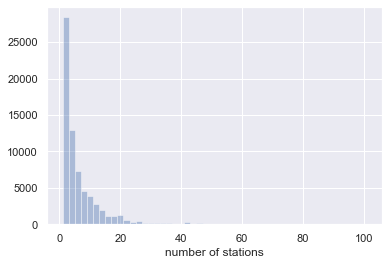

In [29]:
sns.distplot(circle_data.num, kde=False).set_xlabel("number of stations")

### the number of non-NaN stations per circle

In [30]:
circle_data.num_notna.describe()

count    68390.000000
mean         1.053180
std          1.383659
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         33.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'number of non-NaN stations')

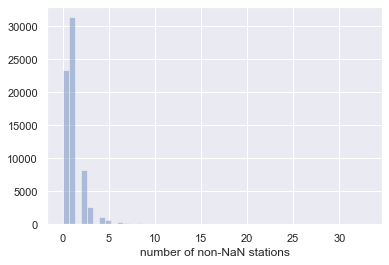

In [31]:
sns.distplot(circle_data.num_notna, kde=False).set_xlabel("number of non-NaN stations")

Text(0.5, 1.0, 'cumulative percent of stations missing')

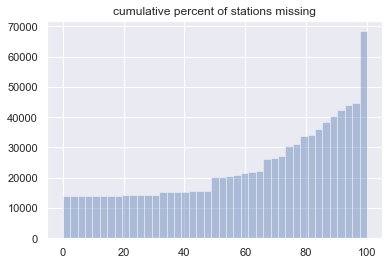

In [32]:
sns.distplot((1 - circle_data.num_notna/circle_data.num) * 100, kde=False, hist_kws={'cumulative': True}).set_title('cumulative percent of stations missing')

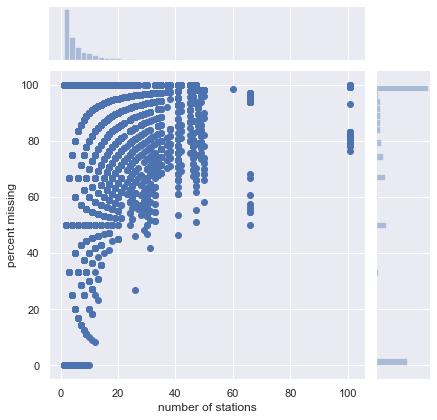

In [33]:
sns.jointplot(circle_data.num, (1 - circle_data.num_notna/circle_data.num) * 100).set_axis_labels("number of stations", 'percent missing')

### percent of circles where all stations are missing data

In [34]:
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

34.19067115075303

### percent of circles where no stations are missing data

In [35]:
(circle_data.num_notna == circle_data.num).sum() / len(circle_data) * 100

20.592191840912413

### percent of circles with less than half of stations missing

In [36]:
((circle_data.num_notna / circle_data.num) >= 0.5).sum() / len(circle_data) * 100

29.76604766778769

### location, location, location

#### what percent of circles had the closest station as NaN?

In [37]:
circle_data.rain_closest.isna().sum() / len(circle_data) * 100

65.28001169761662

what percent had the average value differ from the closest value (ignoring NaNs)?

In [39]:
# use kleene logical indexing to skip over NAs
(circle_data.rain_closest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.07164790174002046

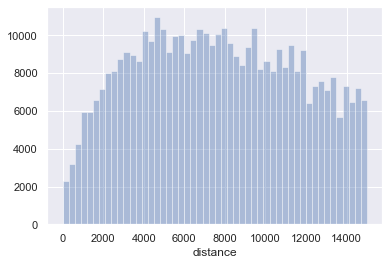

In [42]:
sns.distplot(prcp_data.distance, kde=False)

#### what percent of circles had the lowest station as NaN?

In [84]:
circle_data.rain_lowest.isna().sum() / len(circle_data) * 100

65.79032022225472

what percent had the average value differ from the lowest value (ignoring NaNs)?

In [83]:
# use kleene logical indexing to skip over NAs
(circle_data.rain_lowest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.07895891212165522

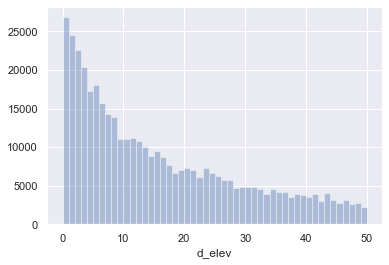

In [82]:
sns.distplot(prcp_data.d_elev, kde=False)

### overall consensus of stations
we use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for rain)

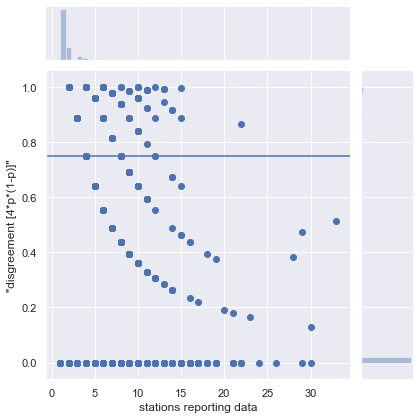

In [129]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p))
p.set_axis_labels("stations reporting data", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [45]:
circle_data.consensus.isna().sum() / len(circle_data) * 100

3.7710191548472003

## the MISSING

In [46]:
circle_data_na_circle_idx = circle_data.c_rain.isna()

### percent of circles with missing rain observation

In [47]:
circle_data_na_circle_idx.sum() / len(circle_data) * 100

50.48983769556953

### percent of circles with both volunteer and all station data are missing

In [48]:
# joint
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / len(circle_data) * 100

15.454013744699518

In [49]:
# conditional 
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / circle_data_na_circle_idx.sum() * 100

30.60816681146829

In [50]:
# population
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

34.19067115075303

correlation between the two

In [51]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna == 0))
g, p

(397.49296252269755, 1.9350377138866115e-88)

if the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

### percent of circles with both volunteer and the closest station data are missing

In [52]:
# joint
(circle_data_na_circle_idx & circle_data.rain_closest.isna()).sum()  / len(circle_data) * 100

27.86664717063898

In [53]:
# conditional 
(circle_data_na_circle_idx & circle_data.rain_closest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

55.192586156964964

In [54]:
# population
circle_data.rain_closest.isna().sum() / len(circle_data) * 100

65.28001169761662

In [55]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.rain_closest.isna()))
g, p

(3130.245692881584, 0.0)

if the circle is missing data, it is much **less** likely that the closes station will have missing data, when compared to the general population

### number of stations for circles with missing data

In [56]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(2412.6366363638845, 0.0)

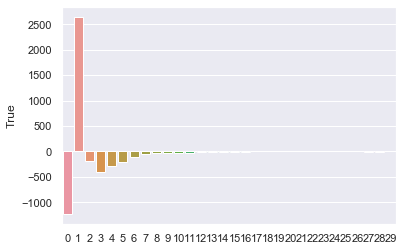

In [57]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### disagreement

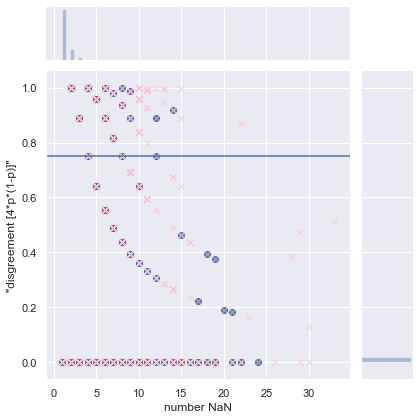

In [58]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.loc[circle_data_na_circle_idx, 'num_notna'], 
                  4 * circle_data.loc[circle_data_na_circle_idx, 'p'] * (1 - circle_data.loc[circle_data_na_circle_idx, 'p']))
p.ax_joint.scatter(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [59]:
# joint
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / len(circle_data) * 100

1.3496125164497734

In [60]:
# conditional
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / circle_data_na_circle_idx.sum() * 100

2.673037938024906

In [61]:
# population
circle_data.consensus.isna().sum() / len(circle_data) * 100

3.7710191548472003

In [62]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.consensus.isna())
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(231.09001195706588, 3.4485104443977666e-52)

In [63]:
actl - expctd

consensus,False,True
c_rain,,
False,-379.132914,379.132914
True,379.132914,-379.132914


missing your rain data imples the stations are more likely to consense

# the truth

get a feel for all the different precipitation measures 

how often does it rain?

In [112]:
circle_data.consensus.sum()/ circle_data.consensus.count()

0.1849234930330796

In [118]:
circle_data.consensus.notna().sum()

65811

In [120]:
(circle_data.num_notna > 0).sum()

45007

In [119]:
circle_data.rain_closest_notna.notna().sum()

45007

In [115]:
(circle_data.consensus.notna() & circle_data.rain_closest_notna.notna()).sum()

42428

In [106]:
pd.crosstab(circle_data.consensus, circle_data.rain_closest_notna).sum(axis=1)

consensus
False    30258
True     12170
dtype: int64

In [81]:
pd.crosstab(circle_data.rain_closest_notna, circle_data.rain_lowest_notna)

rain_lowest_notna,False,True
rain_closest_notna,,
False,30903,568
True,567,12808


# the found

### based on the closest station

In [64]:
actl = pd.crosstab(circle_data.rain_closest_notna, circle_data.c_rain)
actl

c_rain,False,True
rain_closest_notna,,
False,11093,1923
True,4036,3994


In [65]:
# condition on volunteer data
actl / actl.sum()

c_rain,False,True
rain_closest_notna,,
False,0.733228,0.324996
True,0.266772,0.675004


In [66]:
# total joint
actl / actl.to_numpy().sum()

c_rain,False,True
rain_closest_notna,,
False,0.527084,0.091371
True,0.191770,0.189775


In [67]:
# accuracy
actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()

0.7168583103677658

In [68]:
# precision
pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
pr

0.6750042251140781

In [69]:
# recall
re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
re

0.49738480697384807

In [70]:
## F1
2 * pr * re / (pr + re)

0.5727396572739657

### based on the stations' consensus

In [71]:
actl = pd.crosstab(circle_data.consensus, circle_data.c_rain)
actl

c_rain,False,True
consensus,,
False,19251,5762
True,3482,3709


In [72]:
# condition on volunteer data
actl / actl.sum()

c_rain,False,True
consensus,,
False,0.846831,0.608383
True,0.153169,0.391617


In [73]:
# total joint
actl / actl.to_numpy().sum()

c_rain,False,True
consensus,,
False,0.597783,0.178922
True,0.108123,0.115172


In [74]:
# accuracy
actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()

0.712954912433238

In [75]:
# precision
pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
pr

0.3916165135677331

In [127]:
# recall
re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
re

0.49099898580121704

In [128]:
## F1
2 * pr * re / (pr + re)

0.5528907922912205

### did atleast one station aggree?

In [152]:
actl = pd.crosstab(circle_data.num_true >= 1, circle_data.c_rain)
actl

c_rain,False,True
num_true,,
False,14887,2205
True,5541,4579


In [153]:
# condition on volunteer data
actl / actl.sum()

c_rain,False,True
num_true,,
False,0.728755,0.325029
True,0.271245,0.674971


In [154]:
# total joint
actl / actl.to_numpy().sum()

c_rain,False,True
num_true,,
False,0.547075,0.081030
True,0.203623,0.168271


In [155]:
# accuracy
actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()

0.7153461708069969

In [156]:
# precision
pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
pr

0.6749705188679245

In [157]:
# recall
re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
re

0.4524703557312253

In [158]:
## F1
2 * pr * re / (pr + re)

0.5417652626597255